### Used extract_var_save_singlefile.py to save a few key variables. Used the single var ncfiles to plot the results here.

In [1]:
%who

Interactive namespace is empty.


In [69]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import sys
import glob

new_path = '/home/566/ad9701/drought_probability/final_code_AU/'
if new_path not in sys.path:
    sys.path.append(new_path)
import validation_functions as myfuncs

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
#WRF_HYDRO_DIR_CTL = '/g/data/w97/ad9701/WRF-Hydro/SEA/wrf_hydro_nwm_public-5.2.0_domain4_4km_LSMonly/trunk/NDHMS/Run/'
#WRF_HYDRO_DIR_LAT = '/g/data/w97/ad9701/WRF-Hydro/SEA/wrf_hydro_nwm_public-5.2.0_domain4_4km_t80_RTon/trunk/NDHMS/Run/'

# the run with channel routing switched on. Are the results the same?
#WRF_HYDRO_DIR_LAT = '/g/data/w28/ad9701/WRF-Hydro/SEA/wrf_hydro_nwm_public-5.2.0_domain4_4km_t80_RTCHon/trunk/NDHMS/Run/'

# simulations without precip correction - how much difference does it make?
WRF_HYDRO_DIR_CTL = '/g/data/w28/ad9701/WRF-Hydro/SEA/wrf_hydro_nwm_public-5.2.0_domain4_4km_LSMonly_monPCorr/trunk/NDHMS/Run/'
#WRF_HYDRO_DIR_LAT = '/g/data/w28/ad9701/WRF-Hydro/SEA/wrf_hydro_nwm_public-5.2.0_domain4_4km_t80_RTCHon_frxt_mask_4g_newCHPARM_monPCorr_GW/trunk/NDHMS/Run/'
WRF_HYDRO_DIR_LAT = '/g/data/w28/ad9701/WRF-Hydro/SEA/wrf_hydro_nwm_public-5.2.0_domain4_4km_t80_RTon_monPCorr/trunk/NDHMS/Run/'

## Domain average plots

In [57]:
def apply_axis_legend_settings(ax, da, legend_loc = 2, draw_legend = True):
    if draw_legend:
        ax.legend(loc = legend_loc)
    ax.set_xlim((da.time[0], da.time[-1]))
    ax.set_xlabel('')
    ax.set_ylabel(da_ctl.name)

def plot_ctl_and_lat_timeseries(ax, da_ctl, da_lat, run_name, linewidth = 2, linestyle = '-', colors = ['black', 'green'],
                                mark_years = True, year_breaks = pd.date_range('2013-12-31', freq='Y', periods=4)):
    ax.plot(da_ctl.time.values, da_ctl.values, linewidth = linewidth, linestyle = linestyle, color = colors[0], label = 'CTL-' + run_name)
    ax.plot(da_lat.time.values, da_lat.values, linewidth = linewidth, linestyle = linestyle, color = colors[1], label = 'LAT-' + run_name)
    if mark_years:
        for xline in year_breaks:
            ax.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

In [2]:
WRF_HYDRO_DIR_CTL='/g/data/w28/ad9701/WRF-Hydro/SEA/runs_wCalibPars_4km/wrf_hydro_nwm_public-5.2.0_domain4_4km_LSMonly_defSoil_defPar/trunk/NDHMS/Run/'
WRF_HYDRO_DIR_LAT='/g/data/w28/ad9701/WRF-Hydro/SEA/runs_wCalibPars_4km/wrf_hydro_nwm_public-5.2.0_domain4_4km_12g_defSoil_defPar/trunk/NDHMS/Run/'
run_name='defSoil_defPar_4km'

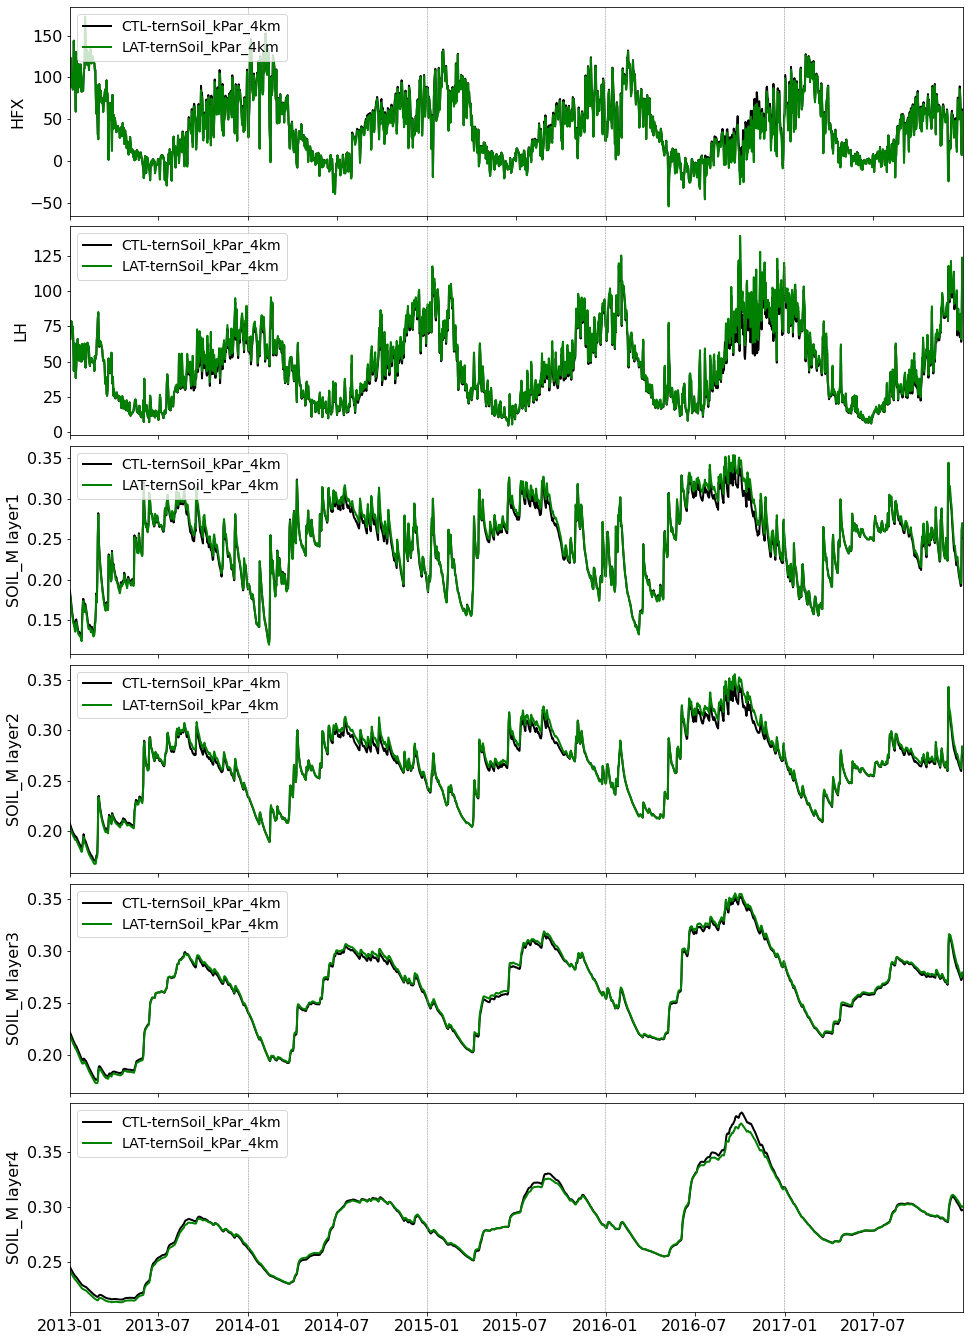

In [80]:
fig_dir = '/home/566/ad9701/figures/wrf_hydro_standalone/finalRuns_4km/domainAvg/'

var_list = ['HFX', 'LH', 'SOIL_M']  # SOIL_M has to be last variable due to the loop over the layers

nrows = len(var_list) + 3    # soil mositure has 4 layers
fig, axs = plt.subplots(nrows=nrows, ncols=1, figsize=(16,4*nrows), sharex='col') #width, height
fig.subplots_adjust(wspace=0.14, hspace=0.05) 

for ivar in range(len(var_list)):
    var = var_list[ivar]
    ds_ctl = xr.open_dataset(WRF_HYDRO_DIR_CTL + 'OUTPUT/DAILY_FILES/' + var + '_daily_mean.nc')
    ds_lat = xr.open_dataset(WRF_HYDRO_DIR_LAT + 'OUTPUT/DAILY_FILES/' + var + '_daily_mean.nc')
    
    if ivar==0:
        ds_CTL_domainAvg = ds_ctl[var].mean(['x', 'y']).to_dataset()
        ds_LAT_domainAvg = ds_lat[var].mean(['x', 'y']).to_dataset()
    else:
        ds_CTL_domainAvg[var] = ds_ctl[var].mean(['x', 'y'])
        ds_LAT_domainAvg[var] = ds_lat[var].mean(['x', 'y'])
    
    if var == 'SOIL_M':
        for ilyr in range(4):            
            da_ctl = ds_CTL_domainAvg[var].isel(soil_layers_stag=ilyr).rename('SOIL_M' + ' layer' + str(ilyr+1))
            da_lat = ds_LAT_domainAvg[var].isel(soil_layers_stag=ilyr).rename('SOIL_M' + ' layer' + str(ilyr+1))
            ax_no = ivar+ilyr
            plot_ctl_and_lat_timeseries(axs[ax_no], da_ctl, da_lat, run_name = run_name)
            apply_axis_legend_settings(axs[ax_no], da_ctl)
    else:
        da_ctl = ds_CTL_domainAvg[var]
        da_lat = ds_LAT_domainAvg[var]
        ax_no = ivar
        plot_ctl_and_lat_timeseries(axs[ax_no], da_ctl, da_lat, run_name = run_name)
        apply_axis_legend_settings(axs[ax_no], da_ctl)

plt.savefig(fig_dir + run_name + '_domainAvg_keyvar.png', dpi = 300, bbox_inches='tight')
plt.savefig(fig_dir + run_name + '_domainAvg_keyvar.pdf', format = 'pdf', bbox_inches='tight')

### The variation from the multiple runs
I have currently performed multiple runs only at 4-km resolution

In [44]:
def read_domainAvg_var_from_allRuns(list_run_dir, var, sm_ilvl = None):
    var_da_list = []
    for run_dir in list_run_dir:
        ds = xr.open_dataset(run_dir + 'OUTPUT/DAILY_FILES/' + var + '_daily_mean.nc')
        if sm_ilvl is not None:
            da = ds[var].isel(soil_layers_stag=sm_ilvl).mean(['x', 'y'])
        else:
            da = ds[var].mean(['x', 'y'])
        var_da_list.append(da)
    return var_da_list

In [67]:
var_list = ['HFX', 'LH', 'SOIL_M']  # SOIL_M has to be last variable due to the loop over the layers

wrf_hydro_ctl_list = ['/g/data/w28/ad9701/WRF-Hydro/SEA/runs_wCalibPars_4km/wrf_hydro_nwm_public-5.2.0_domain4_4km_LSMonly_defSoil_defPar/trunk/NDHMS/Run/',
                      '/g/data/w28/ad9701/WRF-Hydro/SEA/runs_wCalibPars_4km/wrf_hydro_nwm_public-5.2.0_domain4_4km_LSMonly_defSoil_kPar/trunk/NDHMS/Run/',
                      '/g/data/w28/ad9701/WRF-Hydro/SEA/runs_wCalibPars_4km/wrf_hydro_nwm_public-5.2.0_domain4_4km_LSMonly_ternSoil_defPar/trunk/NDHMS/Run/',
                      '/g/data/w28/ad9701/WRF-Hydro/SEA/runs_wCalibPars_4km/wrf_hydro_nwm_public-5.2.0_domain4_4km_LSMonly_ternSoil_kPar/trunk/NDHMS/Run/']

wrf_hydro_lat_list = ['/g/data/w28/ad9701/WRF-Hydro/SEA/runs_wCalibPars_4km/wrf_hydro_nwm_public-5.2.0_domain4_4km_12g_defSoil_defPar/trunk/NDHMS/Run/',
                      '/g/data/w28/ad9701/WRF-Hydro/SEA/runs_wCalibPars_4km/wrf_hydro_nwm_public-5.2.0_domain4_4km_12g_defSoil_kPar/trunk/NDHMS/Run/',
                      '/g/data/w28/ad9701/WRF-Hydro/SEA/runs_wCalibPars_4km/wrf_hydro_nwm_public-5.2.0_domain4_4km_12g_ternSoil_defPar/trunk/NDHMS/Run/',
                      '/g/data/w28/ad9701/WRF-Hydro/SEA/runs_wCalibPars_4km/wrf_hydro_nwm_public-5.2.0_domain4_4km_12g_ternSoil_kPar/trunk/NDHMS/Run/']

run_name_list = ['defSoil_defPar_4km', 'defSoil_kPar_4km', 'ternSoil_defPar_4km', 'ternSoil_kPar_4km']

domainAvg_ctl = {}
domainAvg_lat = {}

for ivar in range(len(var_list)):
    var = var_list[ivar]
    if var == 'SOIL_M':
        sm_ilvl_list = list(range(4))
    else:
        sm_ilvl_list = [None]
    for sm_ilvl in sm_ilvl_list:
        if sm_ilvl is None:
            var_wlvl = var
        else:
            var_wlvl = var + '_ly' + str(sm_ilvl+1)
        var_da_ctl_list = read_domainAvg_var_from_allRuns(wrf_hydro_ctl_list, var, sm_ilvl)
        da_ctl_allruns = xr.concat(var_da_ctl_list, dim = 'run').assign_coords({'run': run_name_list})
        domainAvg_ctl.update({var_wlvl: da_ctl_allruns})
        
        var_da_lat_list = read_domainAvg_var_from_allRuns(wrf_hydro_lat_list, var, sm_ilvl)
        da_lat_allruns = xr.concat(var_da_lat_list, dim = 'run').assign_coords({'run': run_name_list})
        domainAvg_lat.update({var_wlvl: da_lat_allruns})

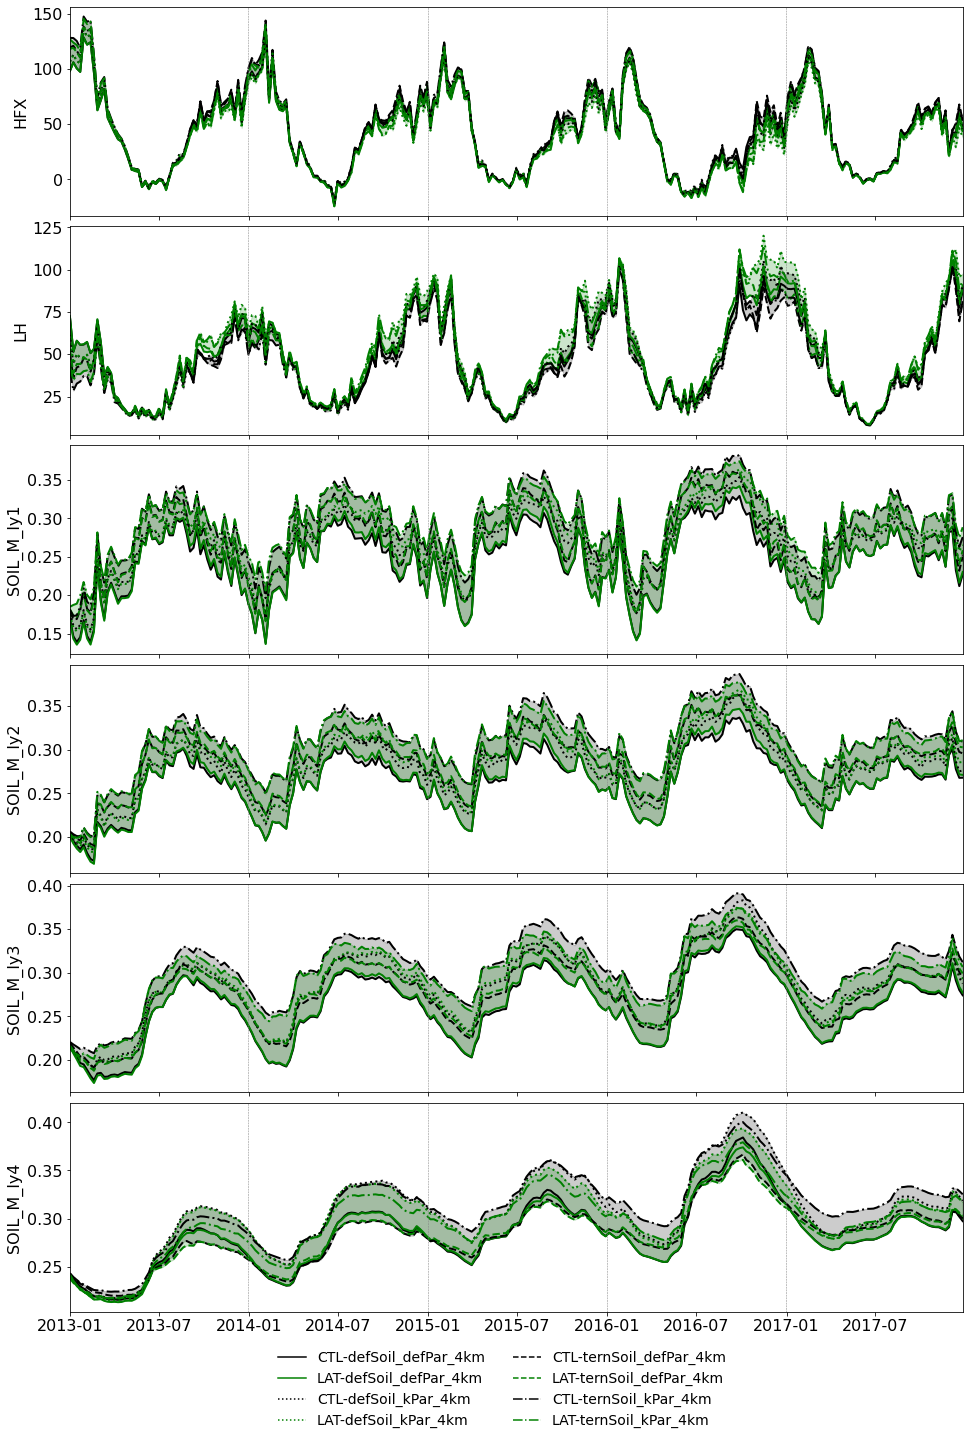

In [77]:
fig_dir = '/home/566/ad9701/figures/wrf_hydro_standalone/finalRuns_4km/domainAvg/'

plot_var_list = ['HFX', 'LH', 'SOIL_M_ly1', 'SOIL_M_ly2', 'SOIL_M_ly3', 'SOIL_M_ly4']

fig, axs = plt.subplots(nrows=len(plot_var_list), ncols=1, figsize=(16,4*nrows), sharex='col') #width, height
fig.subplots_adjust(wspace=0.14, hspace=0.05) 

linestyle_list = ['solid', 'dotted', 'dashed', 'dashdot']
run_name_list = domainAvg_ctl[plot_var_list[0]].run.values
color_list = ['black', 'green']

time_smooth = '7D'

for ivar in range(len(plot_var_list)):
    # shade the range of ctl & lat
    data_list = [domainAvg_ctl[plot_var_list[ivar]].resample(time = time_smooth).mean(), domainAvg_lat[plot_var_list[ivar]].resample(time = time_smooth).mean()]
    shade_alpha = 0.2
    for domainAvg, color in zip(data_list, color_list):
        da_mdl_min = domainAvg.min('run')
        da_mdl_max = domainAvg.max('run')
        axs[ivar].fill_between(da_mdl_min.time.values, da_mdl_min.values, da_mdl_max.values, color=color, alpha=shade_alpha)

    # now draw lines for each run
    for irun in range(len(run_name_list)):
        da_ctl = domainAvg_ctl[plot_var_list[ivar]].isel(run=irun).rename(plot_var_list[ivar]).resample(time = time_smooth).mean()
        da_lat = domainAvg_lat[plot_var_list[ivar]].isel(run=irun).rename(plot_var_list[ivar]).resample(time = time_smooth).mean()
        if irun == len(run_name_list)-1:
            mark_years = True
        else:
            mark_years = False
        plot_ctl_and_lat_timeseries(axs[ivar], da_ctl, da_lat, run_name = run_name_list[irun], linestyle = linestyle_list[irun], mark_years = mark_years)
    apply_axis_legend_settings(axs[ivar], da_ctl, draw_legend=False)

legend_elements = []
for run_name, irun in zip(run_name_list, range(len(run_name_list))):
    legend_elements.append(Line2D([0], [0], linestyle=linestyle_list[irun], color=color_list[0], label='CTL-'+run_name_list[irun]))
    legend_elements.append(Line2D([0], [0], linestyle=linestyle_list[irun], color=color_list[1], label='LAT-'+run_name_list[irun]))
    
fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.08), ncol=2, frameon=False)

plt.savefig(fig_dir + 'allruns_domainAvg_keyvar_' + time_smooth + 'smooth.png', dpi = 300, bbox_inches='tight')
plt.savefig(fig_dir + 'allruns_domainAvg_keyvar_' + time_smooth + 'smooth.pdf', format = 'pdf', bbox_inches='tight')